## Some ideas

1. 我們有已經 label 成 same question 的 data ，那我們也許可以另外 train 一個 model 可以根據 input 的句子 sequential 生成新的"換句話說"句子?
2. curriculum learning
3. Ensombling:

        a. Naive RNN
        b. xgboost
        

---

1. Since we already have data that labelled as same question paris. Is it possible for us to train another model which can sequetially generate a same question string depends on the input? 

In [10]:
import numpy as np
import pandas as pd
import re
import pickle
import json
import matplotlib.pyplot as plt
import random

from keras.layers.embeddings import Embedding

In [11]:
dec_map = pickle.load(open('../dataset/processed/dec_map.pkl','rb'))
enc_map = pickle.load(open('../dataset/processed/enc_map.pkl','rb'))
embedding_matrix = pickle.load(open('../dataset/processed/embedding_matrix.pkl','rb'))

df_train = pickle.load(open('../dataset/processed/processed_training_data.pkl','rb'))
df_test = pickle.load(open('../dataset/processed/processed_testing_data.pkl','rb'))

In [12]:
df_train.head(10)

,id,question1,question2,is_duplicate
0,0,"[26625, 43141, 57411, 55827, 31399, 55827, 404...","[26625, 43141, 57411, 55827, 31399, 55827, 404...",0
1,1,"[26625, 43141, 57411, 55969, 47825, 14349, 3, ...","[26625, 60703, 40671, 41866, 57411, 12894, 401...",0
2,2,"[12206, 31554, 12357, 42227, 57411, 55391, 478...","[12206, 31554, 13085, 55391, 30025, 42228, 313...",0
3,3,"[26684, 28375, 12357, 45770, 59618, 3, 12206, ...","[9985, 57411, 52273, 60339, 5, 43141, 36203, 3...",0
4,4,"[26647, 47944, 36110, 42124, 60109, 51346, 3, ...","[26647, 38748, 60703, 56632, 42124, 53383, 6]",0
5,5,"[3, 12357, 28375, 27360, 6043, 23904, 6028, 46...","[6, 27360, 58322, 6043, 7, 17002, 28557, 29128...",1
6,6,"[22878, 12357, 31386, 3]","[26625, 43643, 4, 27702, 28557, 38317, 39406, ...",0
7,7,"[12206, 31554, 12357, 30025, 27360, 40065, 3]","[26625, 54399, 12357, 36245, 57764, 30025, 273...",1
8,8,"[26640, 36245, 60925, 59299, 3, 42678, 47825, 4]","[26640, 36245, 60925, 59299, 5, 42678, 47825, 6]",0
9,9,"[17083, 3, 5988, 12357, 40523, 46866, 6367, 4, 5]","[12206, 36245, 12357, 40523, 17083, 7545, 3908...",0


In [13]:
def enc_question(question, enc_map):
    
    if type(question)!=str or question=="":
        return [enc_map['<ST>'], enc_map['<ED>']]
    
    def map_wrod(word):
        return enc_map[word] if word in enc_map else enc_map['<RARE>']
         
    
    # identify special characters that separate words : (space) ' ! " ? @ ^ + * / . , ~ ( ) [ ] { } & | ` $ % = : ; < >  
    separator = '(?=[\s\'!"?@\^+*/\.,~\(\)\[\]\{\}\&\|`\$\%\=:;\<\>]|$)'
    single_word = '[\S]+' # non-empty is enough here
    
    words_list = re.findall(single_word+separator, question)
    
    return [enc_map['<ST>']] + [map_wrod(word) for word in words_list] + [enc_map['<ED>']] 
    
    
def dec_question(question, dec_map):
    return [dec_map[enc_value] for enc_value in question]

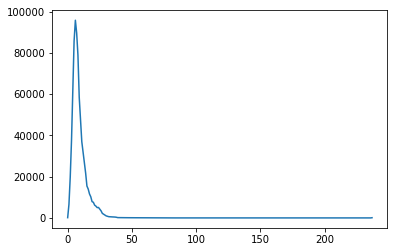

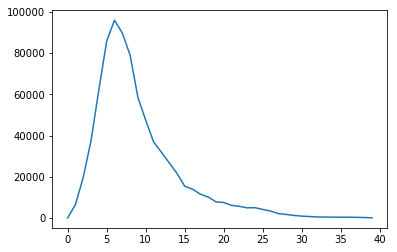

0.008973756461945634  ratio data is longer than 30 words


In [15]:
len_counter = [0]*238 # longest question is 237 words long

for i,data in df_train.iterrows():
    q1 = data['question1']
    q2 = data['question2']
    
    len_counter[len(q1)-2] += 1
    len_counter[len(q2)-2] += 1
        

plt.plot(len_counter)
plt.show()

plt.plot(len_counter[0:40])
plt.show()

print(sum(len_counter[30:])/sum(len_counter), ' ratio data is longer than 30 words')

#### so, use 30 words as length of model input/output

In [5]:
def change_to_list_and_clip(data, clip_st_ed=False):
    
    clip_len = 30
    
    if clip_st_ed:
        data['question1'] = data['question1'][1:-1]
        data['question2'] = data['question2'][1:-1]
    
    if len(data['question1'])<clip_len:
        data['question1'] = data['question1'] + [enc_map['<ED>']] * (30-len(data['question1']))
    else:
        data['question1'] = data['question1'][:30]
        
    if len(data['question2'])<clip_len:
        data['question2'] = data['question2'] + [enc_map['<ED>']] * (30-len(data['question2']))
    else:
        data['question2'] = data['question2'][:30]
        
    return data

In [7]:
df_transformed = df_train.apply(change_to_list_and_clip, axis=1)
pickle.dump(df_transformed, open('../dataset/processed/df_train_hubertLin_version.pkl', 'wb'))

In [8]:
df_transformed = pickle.load(open('../dataset/processed/df_train_hubertLin_version.pkl', 'rb'))

diff_questions = df_transformed.where(df_transformed['is_duplicate']==0).dropna().reset_index(drop=True)
same_questions = df_transformed.where(df_transformed['is_duplicate']==1).dropna().reset_index(drop=True)

pickle.dump(diff_questions, open('../dataset/processed/df_train_diff_hubertLin_version.pkl', 'wb'))
pickle.dump(same_questions, open('../dataset/processed/df_train_same_hubertLin_version.pkl', 'wb'))

In [6]:
df_transformed = df_test.apply(change_to_list_and_clip, axis=1)
pickle.dump(df_transformed, open('../dataset/processed/df_test_hubertLin_version.pkl', 'wb'))

## model time!

In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import json
import matplotlib.pyplot as plt
import random

from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [2]:
dec_map = pickle.load(open('../dataset/processed/dec_map.pkl','rb'))
enc_map = pickle.load(open('../dataset/processed/enc_map.pkl','rb'))
embedding_matrix = pickle.load(open('../dataset/processed/embedding_matrix.pkl','rb'))

In [3]:
def holdout(df, ratio=0.025): # we have 400,000 training data, 10000 for validation is enough
    def gen_suffle_idx(arr):
        random.shuffle(arr)
        return arr
    
    holdout_size = int(len(df)*ratio)
    idxes = gen_suffle_idx(np.arange(len(df)))
    holdout_idxes = idxes[:holdout_size]
    train_idxes = idxes[holdout_size:]
    
    df_train = df.iloc[train_idxes].dropna().reset_index(drop=True)
    df_val   = df.iloc[holdout_idxes].dropna().reset_index(drop=True)
    
    return df_train, df_val


In [4]:
from keras.layers import Input, GRU, Reshape, Dense, merge, Dropout, BatchNormalization, LSTM, MaxoutDense
from keras.models import Model
from keras.optimizers import RMSprop

from keras.layers.noise import GaussianNoise

from keras.callbacks import EarlyStopping

def naive_model():

    # hyper-parameters that should be passed as function argument
    
    EMBEDDING_SIZE = 300
    vocab_size = len(enc_map)
    vocab_dim = EMBEDDING_SIZE # in my case is 300
    text_length = 30 # how many words are we going to feed in one time
    clipnorm = 1
    
    lstm_output = 128

#     gru = GRU(256, dropout=0.2)
    gru = LSTM(lstm_output, dropout=0.5, recurrent_dropout=0.5)
    
    # embed our encoded question to embedded vector

    encoded_question_input1 = Input(shape=(text_length,))

    x = Embedding(output_dim = vocab_dim, 
                  input_dim = vocab_size, 
                  init = 'glorot_uniform',       # to be honest, I don't know what is this
                  input_length = text_length, 
                  weights = [embedding_matrix]   # our embedding_matrix
                 )(encoded_question_input1)
    x = GaussianNoise(0.1)(x)
    text_embedded1 = Reshape((1,vocab_dim*text_length))(x)
    gru1 = gru(text_embedded1)

    
    # embed our encoded question to embedded vector

    encoded_question_input2 = Input(shape=(text_length,))

    x = Embedding(output_dim = vocab_dim, 
                  input_dim = vocab_size, 
                  init = 'glorot_uniform',       # to be honest, I don't know what is this
                  input_length = text_length, 
                  weights = [embedding_matrix]   # our embedding_matrix
                 )(encoded_question_input2)
    x = GaussianNoise(0.1)(x)
    text_embedded2 = Reshape((1,vocab_dim*text_length))(x)
    gru2 = gru(text_embedded2)
    

    # feed to RNN model
    x = merge([gru1, gru2], mode='concat', concat_axis=-1)

    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)

#     x = Dense(60, activation='relu')(x)
    x = MaxoutDense(lstm_output//2)(x) # ex: MaxoutDense(output_dim=1,nb_feature=3,input_dim=1)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)

    out = Dense(1, activation='sigmoid')(x)
    
    # compile the model
    
    model = Model(input=[encoded_question_input1, encoded_question_input2], output=out)
    # choose objective and optimizer
#     model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-3))
    model.compile(loss='binary_crossentropy', optimizer='nadam')
    
    return model

In [5]:
model = naive_model()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=300, input_length=30, embeddings_initializer="glorot_uniform", input_dim=61203, weights=[array([[-...)`
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=300, input_length=30, embeddings_initializer="glorot_uniform", input_dim=61203, weights=[array([[-...)`
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\User\Anaconda3\lib\site-packages\keras\legacy\layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\User\Anac

#### Train on all data directly. Overcome the imbalance problem by directly assign weights for each class label

In [6]:
test_set_pos_label_ratio = 0.1746

weights = {
    0: 1.309028344,
    1: 0.472001959
}


In [7]:
df_transformed = pickle.load(open('../dataset/processed/df_train_hubertLin_version.pkl', 'rb'))

df_transformed, df_validation = holdout(df_transformed, ratio=0.025)

X_train = [np.vstack(df_transformed['question1']), np.vstack(df_transformed['question2'])]
y_train = np.vstack(df_transformed['is_duplicate'])

X_val = [np.vstack(df_validation['question1']), np.vstack(df_validation['question2'])]
y_val = np.vstack(df_validation['is_duplicate'])


In [8]:
test_set_pos_label_ratio = 0.1746

pos_labels = df_transformed['is_duplicate']==1
pos_label_ratio = sum(pos_labels)/len(pos_labels)
weights = {
    0: (1-test_set_pos_label_ratio) / (1-pos_label_ratio),
    1: test_set_pos_label_ratio/pos_label_ratio
}

pos_labels = y_val==1
pos_label_ratio = sum(pos_labels)/len(pos_labels)
validation_weights = np.repeat(weights[1], len(y_val))
validation_weights[y_val.reshape(len(y_val))==0] = weights[0]

In [9]:
import random

batch_size = 128

def gen_batch(X,y):
    size = len(y)
    
    while True:
        
        rnd_idxes = [random.randint(0,size-1) for i in range(batch_size)]
        
        yield [X[0][rnd_idxes], X[1][rnd_idxes]], y[rnd_idxes]

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
]
    
try:
#     model.fit(X_train, 
#               y_train,
#               class_weight=weights,
#               epochs=1000, 
#               batch_size=512,
#               shuffle=True,
#               validation_data=(X_val,y_val,validation_weights), 
#               callbacks=callbacks,
#               verbose=1)
    
    model.fit_generator(gen_batch(X_train,y_train),
                        steps_per_epoch=50,
                        class_weight=weights,
                        epochs=1000,
                        validation_data=(X_val,y_val,validation_weights), 
                        callbacks=callbacks)
    
except KeyboardInterrupt:
    print('\nEarly stop by user')

Epoch 1/1000
50/50 [==============================] - 31s - loss: 0.7475 - val_loss: 0.5179
Epoch 2/1000
50/50 [==============================] - 27s - loss: 0.5189 - val_loss: 0.4525
Epoch 3/1000
50/50 [==============================] - 27s - loss: 0.4603 - val_loss: 0.4401
Epoch 4/1000
50/50 [==============================] - 27s - loss: 0.4482 - val_loss: 0.4338
Epoch 5/1000
50/50 [==============================] - 27s - loss: 0.4327 - val_loss: 0.4467
Epoch 6/1000
50/50 [==============================] - 28s - loss: 0.4456 - val_loss: 0.4270
Epoch 7/1000
50/50 [==============================] - 28s - loss: 0.4360 - val_loss: 0.4236
Epoch 8/1000
50/50 [==============================] - 28s - loss: 0.4346 - val_loss: 0.4151
Epoch 9/1000
50/50 [==============================] - 28s - loss: 0.4278 - val_loss: 0.4098
Epoch 10/1000
50/50 [==============================] - 28s - loss: 0.4230 - val_loss: 0.4077
Epoch 11/1000
50/50 [==============================] - 28s - loss: 0.4064 - val

In [15]:
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score

pred = model.predict(X_val)

pred[pred==1] = 0.999999
pred[pred==0] = 0.000001

print('log_loss=',log_loss(y_val, pred, sample_weight=validation_weights))
print('roc_auc=',roc_auc_score(y_val, pred, sample_weight=validation_weights))

log_loss= 0.349204152869
roc_auc= 0.833908597103


commonly overfit around loss ~ 0.34

#### Train on batch , uses unsampling/downsampling to gaurantee the pos/neg labels are balanced

In [3]:
diff_questions = pickle.load(open('../dataset/processed/df_train_diff_hubertLin_version.pkl', 'rb'))
same_questions = pickle.load(open('../dataset/processed/df_train_same_hubertLin_version.pkl', 'rb'))

diff_questions, diff_val = holdout(diff_questions)
same_questions, same_val = holdout(same_questions)

In [26]:
batch_size = 512

def gen_suffle_idx(arr):
    random.shuffle(arr)
    return arr

def data_gen():
    a = np.arange(batch_size)
    while True:
        
        rand = [random.randint(0,len(same_questions)-1) for i in range(batch_size//2)]
        pos_selected = same_questions.ix[rand]
        rand = [random.randint(0,len(diff_questions)-1) for i in range(batch_size//2)]
        neg_selected = diff_questions.ix[rand]
        
        selected  = pos_selected.append(neg_selected).reset_index(drop=True)
        selected = selected.ix[gen_suffle_idx(a)]

#         batch_size = len(sanity_check)
#         a = np.arange(batch_size)
#         selected = sanity_check.ix[gen_suffle_idx(a)]
        
        q1 = np.array([data['question1'] for i,data in selected.iterrows()])
        q2 = np.array([data['question2'] for i,data in selected.iterrows()])
        
        # randomly swap two training question pair
        swap_idxes = [random.randint(0,len(selected)-1) for i in range(batch_size//2)]
        for i in swap_idxes:
            q1[i] , q2[i] = q2[i] , q1[i]
        
        y = np.array([data['is_duplicate'] for i,data in selected.iterrows()])

        yield [q1, q2], y

def gen_validation(size):
    
    a = np.arange(size)
    
    rand = [random.randint(0,len(same_val)-1) for i in range(size//2)]
    pos_selected = same_val.ix[rand]
    rand = [random.randint(0,len(diff_val)-1) for i in range(size//2)]
    neg_selected = diff_val.ix[rand]
    
    selected  = pos_selected.append(neg_selected).reset_index(drop=True)
    selected = selected.ix[gen_suffle_idx(a)]

    q1 = np.array([data['question1'] for i,data in selected.iterrows()])
    q2 = np.array([data['question2'] for i,data in selected.iterrows()])

    y = np.array([data['is_duplicate'] for i,data in selected.iterrows()])

    return [q1, q2], y, class_weights
    
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
]
    
try:
    validation_data = gen_validation(10000)
    model.fit_generator(data_gen(), 50, epochs=1000, validation_data=validation_data, callbacks=callbacks)
except KeyboardInterrupt:
    print('\nEarly stop by user')

Train on 404290 samples, validate on 10000 samples
Epoch 1/1000
 73728/404290 [====>.........................] - ETA: 309s - loss: 0.5912
Early stop by user


loss 約 converge 在 0.49~0.5

In [ ]:
for i in range(20):
    q = diff_questions.ix[i]
    x1 = np.array([q['question1']])
    x2 = np.array([q['question2']])
    print(model.predict([x1,x2])[0][1])
    

In [ ]:
# def predict(i,q):
    
#     x1 = np.array([list(q['question1'])])
#     x2 = np.array([list(q['question2'])])
#     return model.predict([x1,x2])[:,1]

# df_test.head()
# for i in range(10):
#     df = same_questions
#     print(dec_question(df.ix[i]['question1'], dec_map))
#     print(dec_question(df.ix[i]['question2'], dec_map))
#     print(predict(i,df.ix[i]))
#     print(df.ix[i]['is_duplicate'])
#     print('\n')

In [15]:
model.save('../model/HubertLin_naive_LSTM120.model')

#### customized testcase

In [24]:
def enc_question_pair(question_pair_list, enc_map, capsulate_st_ed=False):

    def enc_question(question):

        if type(question)!=str or question=="":
            if capsulate_st_ed:
                return [enc_map['<ST>'], enc_map['<ED>']]
            else:
                return []

        def map_wrod(word):
            if word in enc_map:
                return enc_map[word]
            elif word in rare_words:
                idx = np.where(np.array(rare_words)==word)[0][0]
                return enc_map['<RARE' + str(idx) + '>']
            else:
                rare_words.append(word)
                return enc_map['<RARE' + str(len(rare_words)-1) + '>']

        # identify special characters that separate words : (space) ' ! " ? @ ^ + * / . , ~ ( ) [ ] { } & | ` $ % = : ; < >  
        separator = '(?=[\s\'!"?@\^+*/\.,~\(\)\[\]\{\}\&\|`\$\%\=:;\<\>\-]|$)'
        single_word = '[^\s\-]+' # non-empty is enough here

        words_list = re.findall(single_word+separator, question)

        if capsulate_st_ed:
            return [enc_map['<ST>']] + [map_wrod(word) for word in words_list] + [enc_map['<ED>']] 
        else:
            return [map_wrod(word) for word in words_list]
        
    # This array is a local cache that identify those non-encoded rare words. 
    # We'll assign identical index (in this question pair) for each of rare words
    rare_words = []
    
    return enc_question(question_pair_list[0]) , enc_question(question_pair_list[1])
    
    
def dec_question(question, dec_map):
    return [dec_map[enc_value] for enc_value in question]

def clip_length(data, clip_st_ed=False):
    
    clip_len = 30
    
    if clip_st_ed:
        data[0] = eval(data[0])[1:-1]
        data[1] = eval(data[1])[1:-1]
    
    if len(data[0])<clip_len:
        data[0] = data[0] + [enc_map['<ED>']] * (30-len(data[0]))
    else:
        data[0] = data[0][:30]
        
    if len(data[1])<clip_len:
        data[1] = data[1] + [enc_map['<ED>']] * (30-len(data[1]))
    else:
        data[1] = data[1][:30]
        
    return data

In [38]:
a = df_test.ix[100]
q1 = dec_question(a['question1'], dec_map)
q2 = dec_question(a['question2'], dec_map)
print(q1)
print(q2)

pred = model.predict([np.array([a['question1']]), np.array([a['question2']])])
print('\nPredicting is same question proba =', pred)

['Which', 'is', 'the', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>']
['Where', 'was', 'training', '<RARE0>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>']

Predicting is same question proba = [[ 0.15064879]]


In [30]:
q1 = 'I am a good man'
q2 = 'A good man is me'

q1 = 'What is your favorite food'
q2 = 'Which is your favorite one'

sp1 = q1.split(' ')
sp2 = q2.split(' ')

enc1, enc2 = enc_question_pair([q1,q2], enc_map)
enc1, enc2 = clip_length([enc1,enc2])
print(dec_question(enc1,dec_map))
print(dec_question(enc2,dec_map))

pred = model.predict([np.array([enc1]), np.array([enc2])])
print('Predicting is same question proba =', pred)


['What', 'is', 'your', 'favorite', 'food', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>']
['Which', 'is', 'your', 'favorite', 'one', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>', '<ED>']
Predicting is same question proba = [[ 0.58142167]]


## Prediction time

In [31]:
from keras.models import load_model

# try:
#     model==None
# except:
#     model = load_model('./model/HubertLin_naive_2_GRU256_same.model')

df_test = pickle.load(open('../dataset/processed/df_test_hubertLin_version.pkl', 'rb'))

In [ ]:
%%time

partition_size = 1000

def predict(i,q):
    
    if i%10 == 0:
        print(i*partition_size, '/', len(df_test))
    
    x1 = np.array(list(q['question1']))
    x2 = np.array(list(q['question2']))
    return model.predict([x1,x2])

partition_len = len(df_test)//partition_size +1
result = [predict(i,df_test.iloc[i*partition_size:(i+1)*partition_size]) for i in range(partition_len)]
con = np.concatenate(result)
df_result = pd.DataFrame({'test_id':np.arange(len(con)),'is_duplicate':con.reshape(len(con))}, columns=['test_id','is_duplicate'])
df_result.to_csv('../result/prediction.csv', index=False)

In [33]:
if len(df_result)!=2345796:
    print('Your result prediction count is not fit to the testing data length 2345796 , yours:', len(df_result))
else:
    print('Prediction success')

Prediction success
